In [2]:
%matplotlib inline
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())       

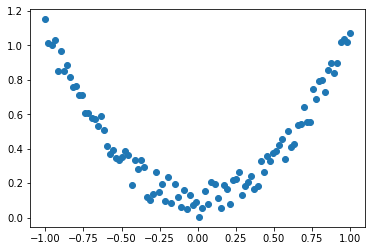

In [3]:
plt.scatter(x.numpy(), y.numpy())

## 搭建两层含有bias的全连接网络，隐藏层输出个数为20，激活函数都用sigmoid()

In [4]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(n_feature, n_hidden, bias=True)
        self.fc2 = torch.nn.Linear(n_hidden, n_output, bias=True)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        self.h_sigmoid = x
        x = self.fc2(x)
        return x

公式推导：

<!-- <img src="计算图推导.png" alt="计算图推导" style="zoom:50%;" /> -->

将其中的结果用公式展示：


$$
\left\{\begin{array}{rl}
\dfrac{\partial L}{\partial Y_{pred}} &= \dfrac{2}{m} (Y - Y_{pred}) \\
B_2 &= \dfrac{\partial L}{\partial Y_{pred}} \\
W_2 &=  \dfrac{\partial L}{\partial Y_{pred}}^T h_{sigmoid} \\
W_1 &= (X^T (\dfrac{\partial L}{\partial Y_{pred}} W_2^T * h_{sigmoid}  *(1-h_{sigmoid})))^T \\
B_1 & = \dfrac{\partial L}{\partial Y_{pred}} W_2 * h_{sigmoid} * (1-h_{sigmoid})
\end{array}\right.
$$

Net(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


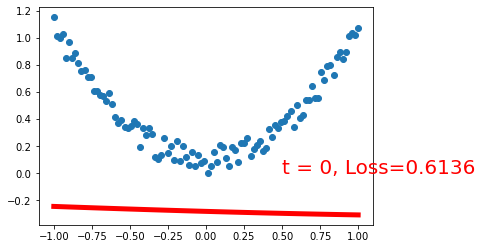

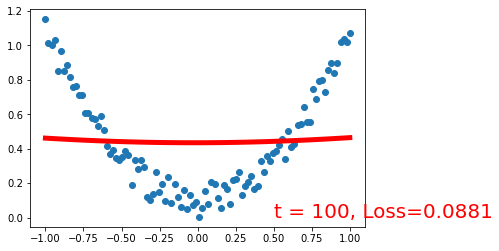

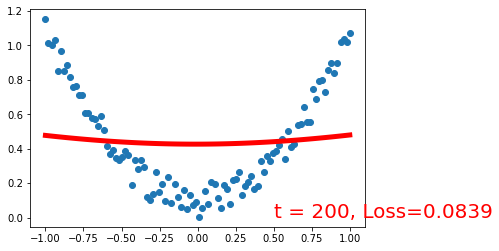

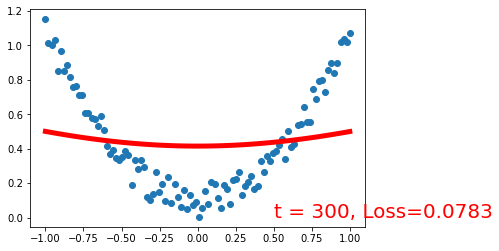

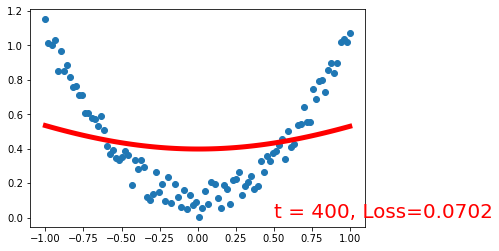

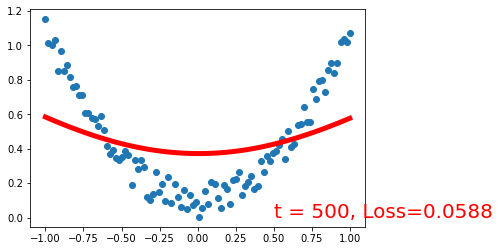

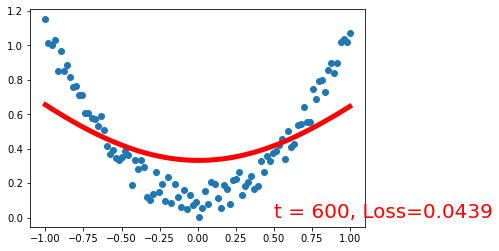

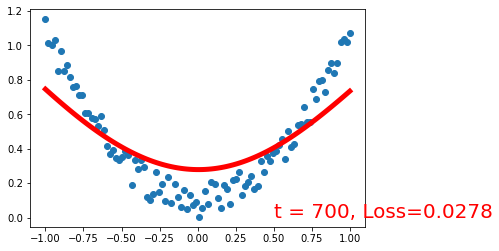

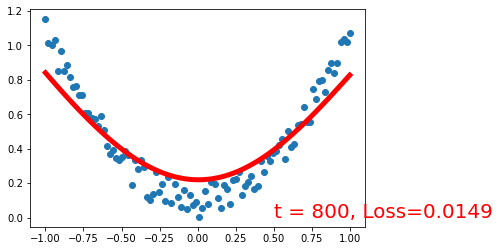

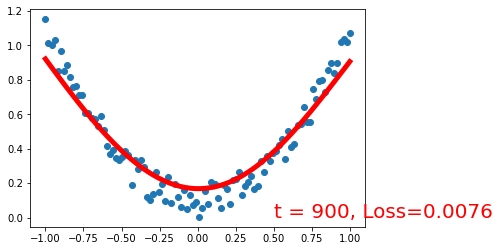

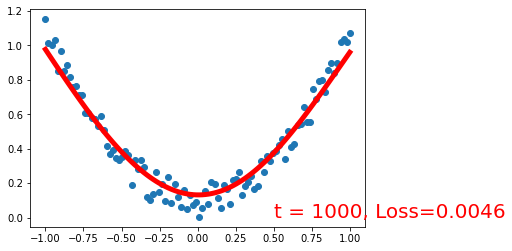

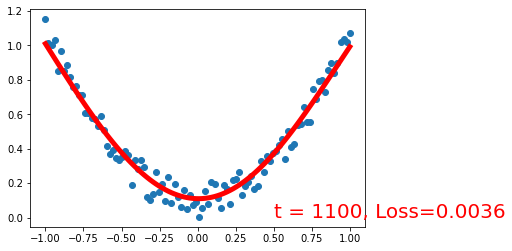

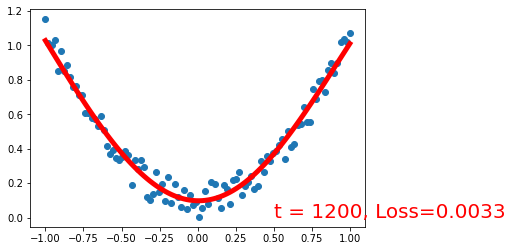

In [6]:
net = Net(n_feature=1, n_hidden=20, n_output=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

plt.ion()   # something about plotting


for t in range(1201):
    prediction = net(x)     # input x and predict based on x
    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 100 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 't = %d, Loss=%.4f' % (t, loss.data.numpy()), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        plt.show()

plt.ioff()
# plt.show()

In [47]:
dL = ((2 / y.shape[0]) * (prediction - y))

B2_grad = dL.sum(dim= 0)
W2_grad = dL.T @ net.h_sigmoid
B1_grad = (dL @ net.fc2.weight) * net.h_sigmoid * (1 - net.h_sigmoid)
W1_grad = (x.T @ ((dL @ net.fc2.weight) * net.h_sigmoid * (1 - net.h_sigmoid))).T

print(B2_grad)
print(W2_grad)
print(B1_grad.shape, B1_grad.sum(dim=0))
print(W1_grad, x.T.shape, (dL @ net.fc2.weight).shape, W1_grad.shape)



for param in net.named_parameters():
    print(param[0], param[1].grad, param[1].grad.shape)

tensor([0.0007], grad_fn=<SumBackward1>)
tensor([[-4.4636e-04,  1.4935e-04,  1.3971e-04,  7.8254e-05, -2.7671e-04,
         -7.8859e-04, -1.0245e-03,  1.4903e-04, -5.2785e-05,  1.9047e-04,
          1.1939e-04, -2.2534e-04, -5.9773e-04, -2.5944e-04,  1.8015e-04,
         -4.5026e-06,  1.2857e-05,  6.8630e-05, -7.2723e-04, -3.2011e-04]],
       grad_fn=<MmBackward>)
torch.Size([100, 20]) tensor([ 7.3385e-05, -2.9184e-05, -3.9006e-05, -1.9037e-06,  1.4319e-04,
         3.8150e-04,  3.7979e-04, -2.6503e-05,  3.5608e-05, -4.7980e-05,
        -2.0566e-05,  6.9761e-05,  2.9836e-04,  1.4729e-04, -5.9530e-05,
         1.6632e-05,  1.0068e-05, -6.8095e-06,  2.9960e-04,  6.3226e-05],
       grad_fn=<SumBackward1>)
tensor([[-4.9321e-04],
        [-2.7864e-05],
        [ 6.0237e-05],
        [ 5.0758e-06],
        [ 3.4839e-04],
        [ 7.5355e-04],
        [-8.4795e-04],
        [ 1.6482e-06],
        [-1.0572e-04],
        [ 2.7854e-05],
        [ 2.9330e-05],
        [-2.8894e-04],
        [-